<a href="https://colab.research.google.com/github/Sangyups/DCGAN/blob/main/DCGAN(with_CelebA).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!git clone https://github.com/Sangyups/etc.git

Cloning into 'etc'...
remote: Enumerating objects: 202481, done.
remote: Counting objects: 100% (202481/202481), done.
remote: Compressing objects: 100% (202478/202478), done.
remote: Total 202481 (delta 0), reused 202478 (delta 0), pack-reused 0
Receiving objects: 100% (202481/202481), 1.29 GiB | 25.27 MiB/s, done.
Checking out files: 100% (202605/202605), done.


In [5]:
!ls

etc  sample_data


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


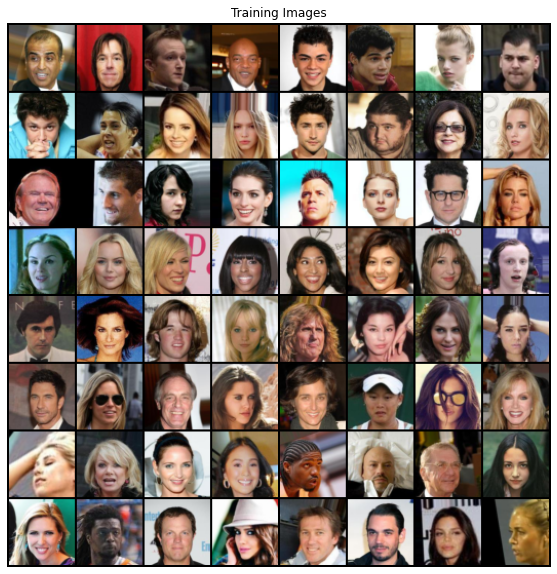

In [16]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils


image_train = datasets.ImageFolder(root="etc/",
                                   transform=transforms.Compose([
                                       transforms.Resize(64),
                                       transforms.CenterCrop(64),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                                   ]))

batch_size = 128

data_train = DataLoader(dataset=image_train,
                        batch_size=batch_size,
                        shuffle=True,
                        drop_last=True,
                        num_workers = 4,
                        )

device = 'cuda' if torch.cuda.is_available() else 'cpu'

real_batch = next(iter(data_train))
plt.figure(figsize=(10,10)) 
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.ConvTranspose2d(100, 1024, 4, 1, 0, bias=False), # 1024*4*4
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False), # 512*8*8
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),  # 256*16*16
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),  # 128*32*32
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.reshape([x.size(0), 100, 1, 1])
        x = self.model(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 128, 4, 2, 1, bias=False), # 128*32*32
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False), #256*16*16
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False), #512*8*8
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1024, 4, 2, 1, bias=False), #1024*4*4
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2),
            nn.Conv2d(1024, 1, 4, 1, 0, bias=False), # 1*1*1
            nn.Sigmoid()
        )
    
    def forward(self,x):
        x = self.model(x)
        x = x.reshape([x.size(0), 1])
        return x


G = Generator().to(device)
G.apply(weights_init)
D = Discriminator().to(device)
D.apply(weights_init)

optim_G = torch.optim.Adam(G.parameters(), lr=0.0002)
optim_D = torch.optim.Adam(D.parameters(), lr=0.0001)
criterion = nn.BCELoss()

start = time.time()
total_epochs = 100
total_batch = len(data_train)

avg_cost = [0, 0]
for epoch in range(total_epochs):
    for x, _ in data_train:
        x = x.to(device)

        z = torch.randn(batch_size, 100, device=device)

        z_img = G(z)
        real = (torch.FloatTensor(x.size(0), 1).fill_(1.0)).to(device)
        fake = (torch.FloatTensor(x.size(0), 1).fill_(0.0)).to(device)
        
        # Train Generator
        optim_G.zero_grad()
        g_cost = criterion(D(z_img), real)
        g_cost.backward()
        optim_G.step()

        z_img = z_img.detach().to(device)
        # Train Discriminator
        optim_D.zero_grad()
        real_cost = criterion(D(x), real)
        fake_cost = criterion(D(z_img), fake)
        d_cost = (real_cost+fake_cost)/2
        d_cost.backward()
        optim_D.step()

        avg_cost[0] += g_cost
        avg_cost[1] += d_cost
        #print(g_cost.item(), d_cost.item())

    avg_cost[0] /= total_batch
    avg_cost[1] /= total_batch

    print("Epoch: %d, Generator: %f, Discriminator: %f"%(epoch+1, avg_cost[0], avg_cost[1]))

    z = torch.randn(64, 100, device=device)
    z_img = G(z)
    img_grid = make_grid(z_img, nrow=8, normalize=True)
    save_image(img_grid, "/content/gdrive/My Drive/Colab Notebooks/DCGAN_result/%d.png"%(epoch+1))

    end = time.time()
    total = int(end-start)
    print("Total Train Time : %dm %ds"%(total//60, total%60))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 1, Generator: 6.034375, Discriminator: 0.053956
Total Train Time : 7m 25s
Epoch: 2, Generator: 7.828958, Discriminator: 0.029921
Total Train Time : 14m 51s
Epoch: 3, Generator: 8.067067, Discriminator: 0.032681
Total Train Time : 22m 16s
Epoch: 4, Generator: 7.325619, Discriminator: 0.033437
Total Train Time : 29m 41s
Epoch: 5, Generator: 7.415152, Discriminator: 0.035804
Total Train Time : 37m 7s
Epoch: 6, Generator: 7.095091, Discriminator: 0.041239
Total Train Time : 44m 32s
Epoch: 7, Generator: 7.002913, Discriminator: 0.044098
Total Train Time : 51m 58s
Epoch: 8, Generator: 6.348660, Discriminator: 0.047201
Total Train Time : 59m 23s
Epoch: 9, Generator: 6.233594, Discriminator: 0.062217
Total Train Time : 66m 49s
Epoch: 10, Generator: 5.840499, Discriminator: 0.060551
Total Train Time : 74m 15s
Epoch: 11, Generator: 6.113107, Discriminator: 0.061208
Total Train Time : 81m 40s
Epoch: 12, Generator: 5.886991, Discriminator: 0.066959
Total Train Time : 89m 6s
Epoch: 13, Gener

In [14]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/
